# Baseline Classifier

In this notebook, I will create two baseline classifiers. One random and one intelligent that will make predictions based off the peak of the sample in the ranges I found in 02_DataExploration.ipynb. 

The peaks for each analyte are at:
- Copper - [660, 720]
- Cadmium - [530, 580]
- Lead - [580, 620]
- Seawater - N/A (it's a flat baseline)

## Random Classifier

Let's see how the model will perform if it guesses the classes 0-3 at random.

In [23]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from functools import partial

from scripts.data_processing import get_class_label_to_int_mapping

CLASS_LABEL_TO_INT_MAPPING = get_class_label_to_int_mapping()

sns.set()

DATA_DIR = Path('data/')

# Read in dataframes - good to keep them separate to make plotting easier
cadmium = pd.read_csv(DATA_DIR / 'cadmium.csv', index_col=0)
copper = pd.read_csv(DATA_DIR / 'copper.csv', index_col=0)
lead = pd.read_csv(DATA_DIR / 'lead.csv', index_col=0)
seawater = pd.read_csv(DATA_DIR / 'seawater.csv', index_col=0)

analytes = pd.read_csv(DATA_DIR / 'all_data.csv', index_col=0)

In [41]:
class RandomClassifier:
    """Returns random predictions of ints in the range 0-3.
    """

    def __init__(self, seed=0):
        np.random.seed(seed)
        self.seed = seed

    def fit(self, X, y=None):
        return self

    def predict(self, X, y=None):
        # Return array len(X) containing ints 0-3 randomly chosen
        return np.random.randint(0, 4, len(X))


class MaxPeakClassifier:
    """Returns predictions based off of the maximum peak value of the sample. 
    """

    def fit(self, X, y=None):
        """
        Blank method to enable use with sklearn API.
        """
        return self

    def predict(self, X, y=None):
        """Predict classes 0-3 for X based off of the max peak value.

        From EDA, we know that the peaks for each analyte occur in the
        following index ranges:
        - Cd - (530, 580)
        - Cu - (660, 720)
        - Pb - (580, 620)

        This method checks the ranges and predicts the analyte with the 
        highest value. However, if the average value of each peak is less 
        than 2.5, it predicts seawater (this value was found through EDA 
        too).

        Parameters
        ----------
        X : np.ndarray or pd.Series or pd.DataFrame
            The object containing voltage series for each analyte. 
            Should be of shape (n_samples, 1002) since each series has len
            1002. 
            
            Note: you can input a single series with shape (1002,) as well.
        y : None, optional
            Placeholder for y to maintain compatibility with sklearn, by default None

        Returns
        -------
        np.ndarray
            1D array containing predictions for each sample as ints. 
            The mapping is:
                Cd - 0
                Cu - 1
                Pb - 2
                Sw - 3
        """
        # Turn Series and DataFrames into NumPy arrays
        if not isinstance(X, np.ndarray):
            X = X.values
        if X.ndim == 1:
            # Reshape single sample 1D inputs to 2D
            X = X.reshape(1, -1)
        # Define peak value ranges
        cu_peak_start = 660
        cu_peak_end = 720

        cd_peak_start = 530
        cd_peak_end = 580

        pb_peak_start = 580
        pb_peak_end = 620

        preds = []
        # Iterate over the rows (i.e. samples) in X
        for sample in X:
            # Get peak values from sample
            cu_peak_value = sample[cu_peak_start:cu_peak_end].max()
            cd_peak_value = sample[cd_peak_start:cd_peak_end].max()
            pb_peak_value = sample[pb_peak_start:pb_peak_end].max()

            peak_values = {
                'Cd': cd_peak_value,
                'Cu': cu_peak_value,
                'Pb': pb_peak_value
                }

            avergae_value = np.mean(list(peak_values.values()))

            # On average, seawater max values are less than 2.5, found by inspection
            if avergae_value <= 2.5:
                pred = CLASS_LABEL_TO_INT_MAPPING['Sw']
                preds.append(pred)
            else:
                analyte_with_biggest_peak = max(peak_values, key=peak_values.get)
                pred = CLASS_LABEL_TO_INT_MAPPING[analyte_with_biggest_peak]
                preds.append(pred)
        return np.array(preds)

    def print_scores(self, X, y, average='micro'):
        """Print accuracy, precision, recall and f1 scores.

        Parameters
        ----------
        X : np.ndarray, pd.Series, pd.DataFrame
            Input array containing samples with shape (n_samples, 1002)
        y : np.ndarray or pd.Series
            True predictions
        average : str, optional
            Determines the averaging performed on the data. Required for 
            multiclass classification. Options are: 'micro' (default),
            ‘micro’, ‘macro’, ‘samples’, ‘weighted’.
        """
        preds = self.predict(X)
        
        scores = {
            'accuracy': accuracy_score, 
            'f1': partial(f1_score, average='micro'), 
            'precision': partial(precision_score, average='micro'),
            'recall': partial(recall_score, average='micro')
        }

        for name, score_func in scores.items():
            if name != 'accuracy':
                print(f'{name}_{average} - {score_func(y, preds):.4f}')
            else:
                print(f'{name} - {score_func(y, preds):.4f}')


In [42]:
max_peak = MaxPeakClassifier()
max_peak_preds = max_peak.predict(analytes)
max_peak_preds

array([0, 0, 3, 3, 3, 0, 3, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 2, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [43]:
max_peak.print_scores(analytes.drop('label', axis=1), analytes.label)

accuracy - 0.8629
f1_micro - 0.8629
precision_micro - 0.8629
recall_micro - 0.8629


In [28]:
len('precision_micro')

15

In [17]:
y_true = analytes.label.values

In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from functools import partial
scores = dict(
    accuracy=accuracy_score, 
    f1=partial(f1_score, average='micro'), 
    precision=partial(precision_score, average='micro'),
    recall=partial(recall_score, average='micro'))


for name, score_func in scores.items():
    print(f'{name:<10} - {score_func(y_true, max_peak_preds)}')
# accuracy = accuracy_score(y_true, max_peak_preds)
# f1 = f1_score(y_true, max_peak_preds)
# precision = precision_score(y_true, max)

accuracy   - 0.8628571428571429
f1         - 0.8628571428571429
precision  - 0.8628571428571429
recall     - 0.8628571428571429


In [18]:
cadmium.iloc[28, :-1]

0      -2.357425
1      -2.419463
2      -2.481500
3      -2.481500
4      -2.419463
          ...   
997     8.995438
998     9.181550
999     9.305625
1000    9.491738
1001    9.615813
Name: Cd_825_ppb_28, Length: 1002, dtype: float64

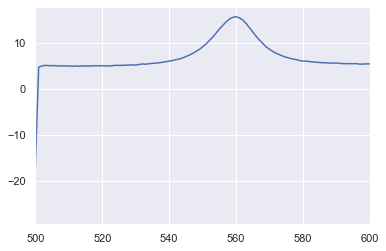

In [21]:
x = cadmium.iloc[28, :-1]
x.index = range(0, 1002)
plt.plot(x)
plt.xlim(500, 600)
plt.show()

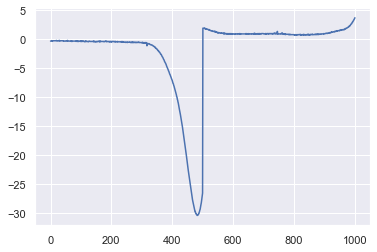

In [30]:
y = seawater.loc['SW0_72'][:-1]
y.index = range(0, 1002)
plt.plot(y)

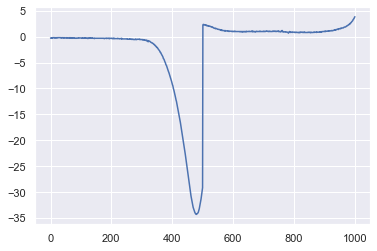

In [34]:
y = seawater.loc['SW0_20'][:-1]
y.index = range(0, 1002)
plt.plot(y)

In [53]:
copper.columns = list(range(0, 1002)) + ['label']
copper.columns

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
           993,     994,     995,     996,     997,     998,     999,    1000,
          1001, 'label'],
      dtype='object', length=1003)

In [56]:
copper.iloc[0, 500:600]

500   -26.055751
501     9.801925
502    10.050075
503    10.112113
504    10.112113
         ...    
595     7.816725
596     7.816725
597     7.754688
598     7.754688
599     7.630613
Name: Cu_500_ppb_0, Length: 100, dtype: float64

In [129]:
# Final col is label
sample = cadmium.iloc[28, :-1]
sample = seawater.loc['SW0_72'][:-1]
# sample = seawater.loc['SW0_20'][:-1]
sample = lead.iloc[15, :-1]
sample = copper.iloc[15, :-1]
# Change to range index to make slicing easy
sample.index = range(0, 1002)

def predict_from_max_peak_value(X, y=None):
    """Predict classes 0-3 for X based off of the max peak value.

    From EDA, we know that the peaks for each analyte occur in the
    following index ranges:
    - Cd - (530, 580)
    - Cu - (660, 720)
    - Pb - (580, 620)

    This method checks the ranges and predicts the analyte with the 
    highest value. However, if the average value of each peak is less 
    than 2.5, it predicts seawater (this value was found through EDA 
    too).

    Parameters
    ----------
    X : np.ndarray or pd.Series or pd.DataFrame
        The object containing voltage series for each analyte. 
        Should be of shape (n_samples, 1002) since each series has len
        1002. 
        
        Note: you can input a single series with shape (1002,) as well.
    y : None, optional
        Placeholder for y to maintain compatibility with sklearn, by default None

    Returns
    -------
    np.ndarray
        1D array containing predictions for each sample as ints. 
        The mapping is:
            Cd - 0
            Cu - 1
            Pb - 2
            Sw - 3
    """
    # Turn Series and DataFrames into NumPy arrays
    if not isinstance(X, np.ndarray):
        X = X.values
    if X.ndim == 1:
        # Reshape single sample 1D inputs to 2D
        X = X.reshape(1, -1)
    # Define peak value ranges
    cu_peak_start = 660
    cu_peak_end = 720

    cd_peak_start = 530
    cd_peak_end = 580

    pb_peak_start = 580
    pb_peak_end = 620

    preds = []
    # Iterate over the rows (i.e. samples) in X
    for sample in X:
        # Get peak values from sample
        cu_peak_value = sample[cu_peak_start:cu_peak_end].max()
        cd_peak_value = sample[cd_peak_start:cd_peak_end].max()
        pb_peak_value = sample[pb_peak_start:pb_peak_end].max()

        peak_values = {
            'Cd': cd_peak_value,
            'Cu': cu_peak_value,
            'Pb': pb_peak_value
            }

        avergae_value = np.mean(list(peak_values.values()))

        # On average, seawater max values are less than 2.5, found by inspection
        if avergae_value <= 2.5:
            pred = CLASS_LABEL_TO_INT_MAPPING['Sw']
            preds.append(pred)
        else:
            analyte_with_biggest_peak = max(peak_values, key=peak_values.get)
            pred = CLASS_LABEL_TO_INT_MAPPING[analyte_with_biggest_peak]
            preds.append(pred)
    return np.array(preds)

In [136]:
predict_from_max_peak_value(np.random.random((5, 800)))

[3, 3, 3, 3, 3]

In [116]:
x = np.random.random((4, 5))
for a in x:
    print(a)

[0.69318644 0.68068666 0.06467985 0.00205114 0.68963068]
[0.46761055 0.21562081 0.58736466 0.77761022 0.99391719]
[0.62514802 0.09479436 0.21667423 0.18891792 0.40407854]
[0.85061667 0.90549172 0.05364608 0.31817309 0.59221481]


In [115]:
sample = seawater.values[1]
sample[500:600].max()

2.136645

In [104]:
seawater.iloc[0].reshape(1, -1).shape

AttributeError: 'Series' object has no attribute 'reshape'

In [82]:
predict_from_max_peak_value(seawater.iloc[0])

Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
Cd
C

In [98]:
x = list(range(1002))
y = np.random.random((5, 1002)).ndim
y
# predict_from_max_peak_value(pd.DataFrame(y))

2